<a href="https://colab.research.google.com/github/Sirfowahid/FFN/blob/master/FNN_BredthVsDepth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')
labels = data[:,0]
data = data[:,1:]
dataNorm = data / np.max(data)

In [4]:
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

train_data,test_data,train_labels,test_labels = train_test_split(dataT,labelsT,test_size=.1)

train_dataset = TensorDataset(train_data,train_labels)
test_dataset = TensorDataset(test_data,test_labels)

batchsize = 32
train_loader = DataLoader(train_dataset,shuffle=True,batch_size=batchsize,drop_last=True)
test_loader = DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0])

In [5]:
def createTheMNISTNet(nUnits,nLayers):

  class mnistNet(nn.Module):

    def __init__(self,nUnits,nLayers):
      super().__init__()

      self.layers = nn.ModuleDict()
      self.nLayers = nLayers

      self.layers['input'] = nn.Linear(784,nUnits)

      for i in range(nLayers):
        self.layers[f'hidden{i}'] = nn.Linear(nUnits,nUnits)
      self.layers['output'] = nn.Linear(nUnits,10)

    def forward(self,x):

      x = self.layers['input'](x)

      for i in range(self.nLayers):
        x = F.relu(self.layers[f'hidden{i}'](x))

      x = self.layers['output'](x)

      return x
  
  net = mnistNet(nUnits,nLayers)

  lossfun = nn.CrossEntropyLoss()

  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [6]:
nUnitsPerLayer = 12
nLayers = 4
net = createTheMNISTNet(nUnitsPerLayer,nLayers)
net

(mnistNet(
   (layers): ModuleDict(
     (input): Linear(in_features=784, out_features=12, bias=True)
     (hidden0): Linear(in_features=12, out_features=12, bias=True)
     (hidden1): Linear(in_features=12, out_features=12, bias=True)
     (hidden2): Linear(in_features=12, out_features=12, bias=True)
     (hidden3): Linear(in_features=12, out_features=12, bias=True)
     (output): Linear(in_features=12, out_features=10, bias=True)
   )
 ), CrossEntropyLoss(), SGD (
 Parameter Group 0
     dampening: 0
     foreach: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

In [9]:
def func2trainTheModel(nUnits,nLayers):

  numepochs = 60

  net,lossfun,optimizer = createTheMNISTNet(nUnits,nLayers)

  losses = []
  trainAcc = []
  testAcc = []

  for epochi in range(numepochs):

    batchLoss = []
    batchAcc = []

    for X,y in train_loader:

      yHat = net(X)
      loss = lossfun(yHat,y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchLoss.append(loss.item())

      matches = torch.argmax(yHat,axis=1) == y
      matchNumeric = matches.float()
      accPct = 100*torch.mean(matchNumeric)
      batchAcc.append(accPct)
    
    trainAcc.append(np.mean(batchAcc))
    losses.append(np.mean(batchLoss))

    X,y = next(iter(test_loader))
    with torch.no_grad():
      yHat = net(X)
    
    testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
  
  return trainAcc,testAcc,losses,net




In [11]:
numlayers = range(1,4)
numunits = np.arange(50,251,50)

accuracies = np.zeros((2,len(numunits),len(numlayers)))

for unitidx in range(len(numunits)):
  for layeridx in range(len(numlayers)):

    trainAcc,testAcc,losses,net = func2trainTheModel(numunits[unitidx],numlayers[layeridx])

    accuracies[0,unitidx,layeridx] = np.mean(trainAcc[-5:])
    accuracies[1,unitidx,layeridx] = np.mean(testAcc[-5:])

    print(f'Finished units {unitidx+1}/{len(numunits)} and layers {layeridx+1}/{len(numlayers)}')

Finished units 1/5 and layers 1/3
Finished units 1/5 and layers 2/3
Finished units 1/5 and layers 3/3
Finished units 2/5 and layers 1/3
Finished units 2/5 and layers 2/3
Finished units 2/5 and layers 3/3
Finished units 3/5 and layers 1/3
Finished units 3/5 and layers 2/3
Finished units 3/5 and layers 3/3
Finished units 4/5 and layers 1/3
Finished units 4/5 and layers 2/3
Finished units 4/5 and layers 3/3
Finished units 5/5 and layers 1/3
Finished units 5/5 and layers 2/3
Finished units 5/5 and layers 3/3


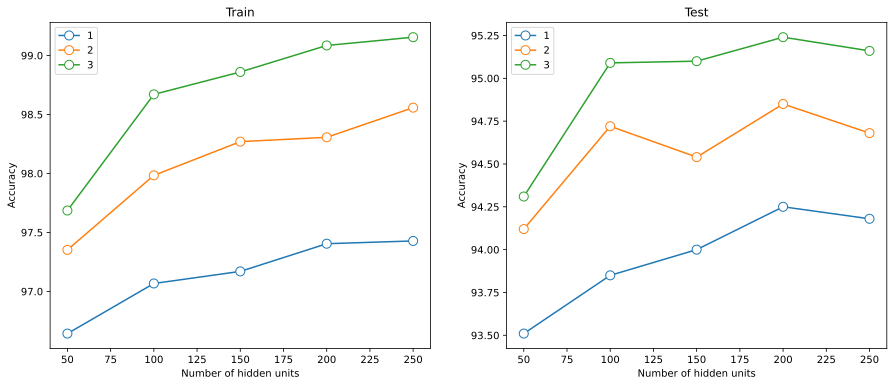

In [13]:
fig,ax = plt.subplots(1,2,figsize=(15,6))

ax[0].plot(numunits,accuracies[0,:,:],'o-',markerfacecolor='w',markersize=9)
ax[1].plot(numunits,accuracies[1,:,:],'o-',markerfacecolor='w',markersize=9)

for i in range(2):
  ax[i].legend(numlayers)
  ax[i].set_ylabel('Accuracy')
  ax[i].set_xlabel('Number of hidden units')
  ax[i].set_title([ 'Train' if i==0 else 'Test' ][0])

plt.show()